In [1]:
import pandas as pd
import numpy as np

In [2]:
dat = pd.read_csv('../MNN2017-master/raw_all.csv', delimiter = ',')
meta = pd.read_csv('../MNN2017-master/all_meta.csv', delimiter = ',')

In [3]:
mv = meta['Sample'].values
dv = dat.columns[1:]
reorder = [np.where(mv == dv[i])[0][0] for i in range(len(dv))]

In [4]:
z = pd.get_dummies(meta['Study'][reorder]).values[:,1:]

In [5]:
mnncorrected = pd.read_csv('../MNN2017-master/Pancreas/Data/mnnCorrected.tsv', delimiter = '\t')

In [6]:
mnn_np = np.array(mnncorrected.values[:,:-1].T, dtype = np.float64)

In [7]:
import h5py

In [8]:
fit = h5py.File('./pancreas-mnn-6-p_full/model-output-final.hdf5','r')

In [9]:
dims = np.sort(np.argsort(np.sum(fit['lengthscales'][0:10,0:2], axis = 1))[0:5])
print(dims)

[1 2 3 5 9]


In [10]:
import matplotlib.pyplot as plt

In [11]:
plt.style.use('seaborn-poster')

In [12]:
from sklearn.cluster import KMeans
from sklearn.metrics import normalized_mutual_info_score, adjusted_rand_score

In [13]:
np.random.seed(10)
n_repeats = 10
clusters = range(5,10)
mnn_results = np.zeros((2,len(clusters),n_repeats))
tgplvm_results = np.zeros((2,len(clusters),n_repeats))
tgplvm_dim_results = np.zeros((2,len(clusters),n_repeats))

In [14]:
true_labs = meta['CellType'][reorder].astype("category").cat.codes.values
sample_labs = meta['Study'][reorder].astype("category").cat.codes.values

In [15]:
for i in range(len(clusters)):
    print(i)
    km = KMeans(n_clusters = clusters[i])
    for j in range(n_repeats):
        labs = km.fit_predict(mnn_np)
        mnn_results[0,i,j] = normalized_mutual_info_score(labs, true_labs)
        mnn_results[1,i,j] = adjusted_rand_score(labs, true_labs)
        
        labs = km.fit_predict(fit['x_mean'][:,0:11])
        tgplvm_results[0,i,j] = normalized_mutual_info_score(labs, true_labs)
        tgplvm_results[1,i,j] = adjusted_rand_score(labs, true_labs)
        
        
        labs = km.fit_predict(fit['x_mean'][:,dims])
        tgplvm_dim_results[0,i,j] = normalized_mutual_info_score(labs, true_labs)
        tgplvm_dim_results[1,i,j] = adjusted_rand_score(labs, true_labs)

0


/Users/architverma/anaconda/lib/python2.7/site-packages/sklearn/metrics/cluster/supervised.py:844: FutureWarning: The behavior of NMI will change in version 0.22. To match the behavior of 'v_measure_score', NMI will use average_method='arithmetic' by default.
  FutureWarning)


1
2
3
4


In [16]:
print(np.mean(mnn_results[1]))
#print(np.mean(tgplvm_results[1]))
print(np.mean(tgplvm_dim_results[1]))

0.42168982982429315
0.34047186491415343


In [17]:
print(np.mean(mnn_results[0]))
#print(np.mean(tgplvm_results[1]))
print(np.mean(tgplvm_dim_results[0]))

0.45483413583828225
0.4245040132898


In [18]:
print(np.mean(mnn_results[1], axis = 1))
#print(np.mean(tgplvm_results[1]))
print(np.mean(tgplvm_dim_results[1], axis = 1))

[0.42677851 0.43029606 0.40565138 0.44719048 0.39853273]
[0.35000442 0.32840513 0.35897088 0.36048759 0.3044913 ]


In [19]:
print(np.mean(mnn_results[0], axis = 1))
#print(np.mean(tgplvm_results[0]))
print(np.mean(tgplvm_dim_results[0], axis = 1))

[0.44237391 0.46144031 0.44712678 0.47201639 0.45121328]
[0.42021515 0.41772762 0.43287096 0.42634358 0.42536276]


In [20]:
n_types = len(meta['CellType'][reorder].unique())
n_vars = np.zeros(n_types)

c = 0
for i in meta['CellType'][reorder].unique():
    mask = meta['CellType'][reorder] == i
    cell_vars = fit['x_var'][mask][:,dims]
    n_vars = np.mean(cell_vars)
    c += 1

/Users/architverma/anaconda/lib/python2.7/site-packages/h5py/_hl/selections.py:358: FutureWarning: Series.nonzero() is deprecated and will be removed in a future version.Use Series.to_numpy().nonzero() instead
  arg = arg.nonzero()[0]


In [21]:
from sklearn.manifold import TSNE

In [22]:
ztsne = TSNE(n_components = 2).fit_transform(fit['x_mean'][:,dims])

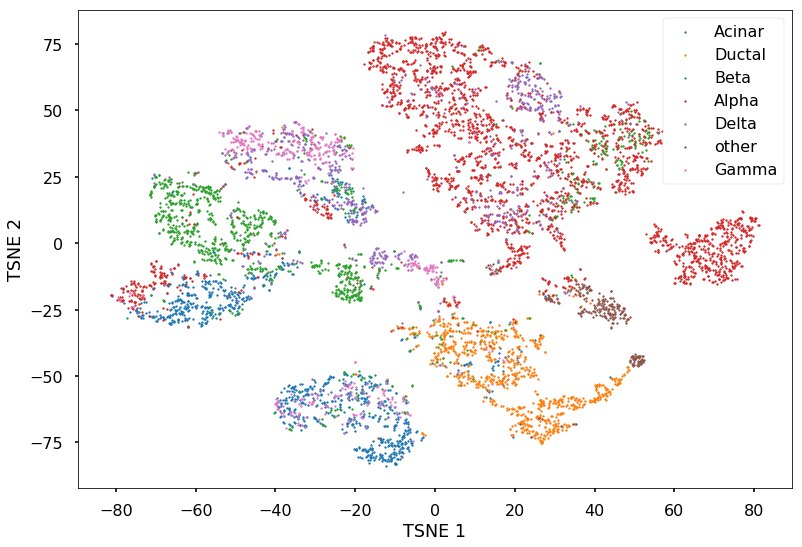

In [23]:
for i in meta['CellType'][reorder].unique():
    mask = meta['CellType'][reorder] == i
    cell = ztsne[mask]
    plt.scatter(cell[:,0], cell[:,1], label = i, s = 3)
plt.legend()
plt.xlabel('TSNE 1')
plt.ylabel('TSNE 2')
plt.show()

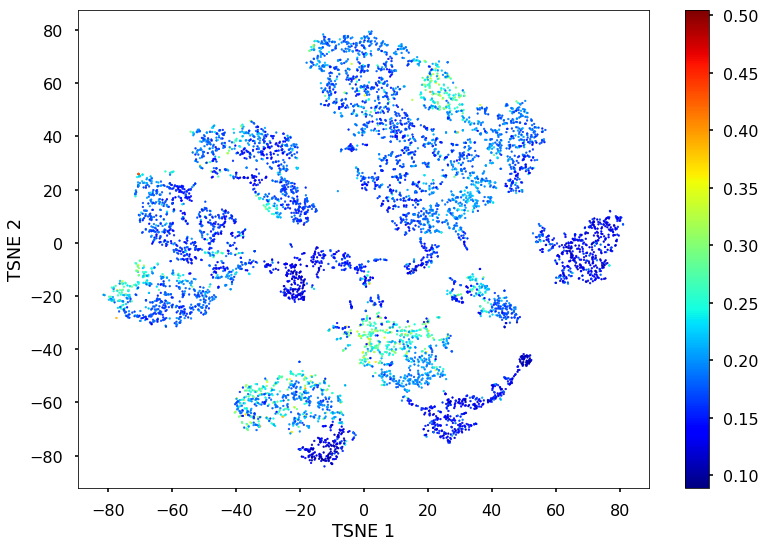

In [24]:
c = np.mean(fit['x_var'][:,dims], axis = 1)
plt.scatter(ztsne[:,0], ztsne[:,1], s = 3, c = c, cmap = 'jet')
plt.colorbar()
plt.xlabel('TSNE 1')
plt.ylabel('TSNE 2')
plt.show()

In [25]:
import umap

In [26]:
emb = umap.UMAP()

In [27]:
z = emb.fit_transform(fit['x_mean'][:,dims])

/Users/architverma/anaconda/lib/python2.7/site-packages/umap/rp_tree.py:439: NumbaWarning: 
Compilation is falling back to object mode WITH looplifting enabled because Function "make_euclidean_tree" failed type inference due to: Cannot unify RandomProjectionTreeNode(array(int64, 1d, C), bool, none, none, none, none) and RandomProjectionTreeNode(none, bool, array(float32, 1d, C), float64, RandomProjectionTreeNode(array(int64, 1d, C), bool, none, none, none, none), RandomProjectionTreeNode(array(int64, 1d, C), bool, none, none, none, none)) for '$19.16', defined at /Users/architverma/anaconda/lib/python2.7/site-packages/umap/rp_tree.py (446)

File "../../../anaconda/lib/python2.7/site-packages/umap/rp_tree.py", line 446:
def make_euclidean_tree(data, indices, rng_state, leaf_size=30):
    <source elided>

        left_node = make_euclidean_tree(data, left_indices, rng_state, leaf_size)
        ^

[1] During: resolving callee type: recursive(type(CPUDispatcher(<function make_euclidean_tre

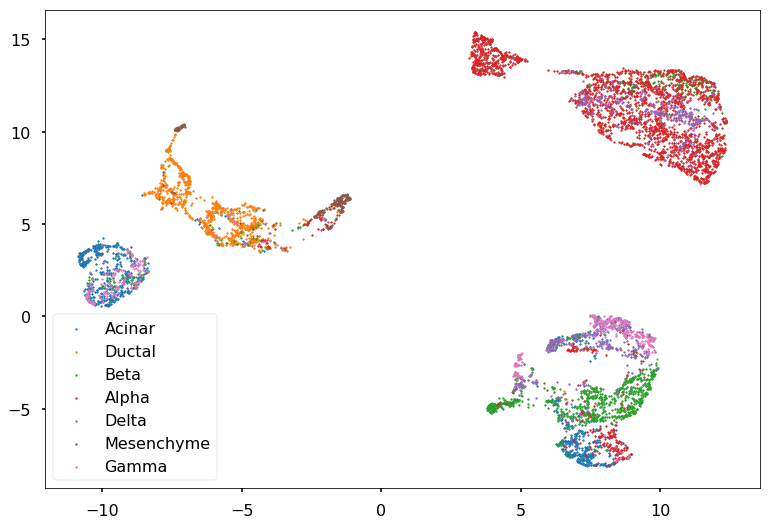

In [28]:
for i in meta['CellType'][reorder].unique():
    mask = meta['CellType'][reorder] == i
    cell = z[mask]
    if i == 'other':
        i = 'Mesenchyme'
    plt.scatter(cell[:,0], cell[:,1], label = i, s = 3)
plt.legend()
plt.show()

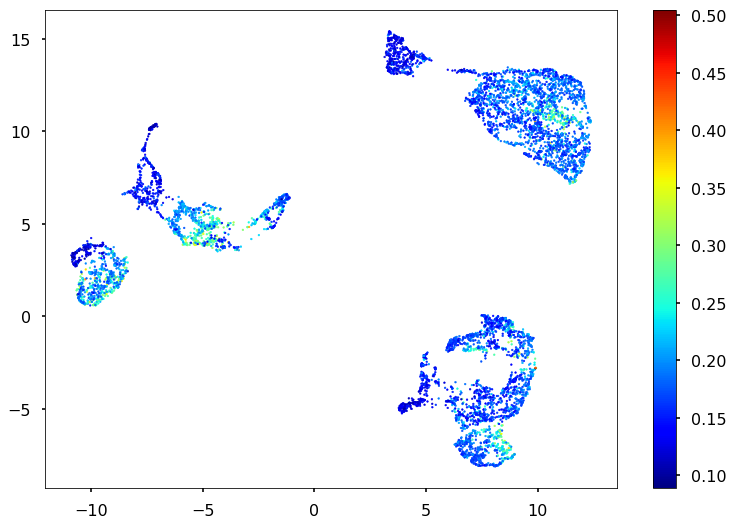

In [29]:
c = np.mean(fit['x_var'][:,dims], axis = 1)
plt.scatter(z[:,0], z[:,1], s = 3, c = c, cmap = 'jet')
plt.colorbar()
plt.show()

In [30]:
from sklearn.neighbors import NearestNeighbors

In [31]:
nn = 5
fit_knn = NearestNeighbors(n_neighbors = nn).fit(fit['x_mean'][:,dims]).kneighbors_graph()

In [32]:
knn_np = np.array(fit_knn.todense())

In [33]:
same_cells = np.zeros(7095)

for i in meta['CellType'][reorder].unique():
    mask = meta['CellType'][reorder] == i
    cells_rows = knn_np[mask]
    cells_columns = cells_rows[:,mask]
    same_cells[mask] = np.sum(cells_columns, axis = 1)

In [34]:
from scipy.stats import linregress

In [35]:
slope, intercept, r_value, p_value, std_err = linregress(same_cells,np.mean(fit['x_var'][:,dims], axis = 1))

In [36]:
slope

-0.00820079004057994

In [37]:
r_value

-0.27186036373458017

In [38]:
p_value

1.9062771521979597e-120

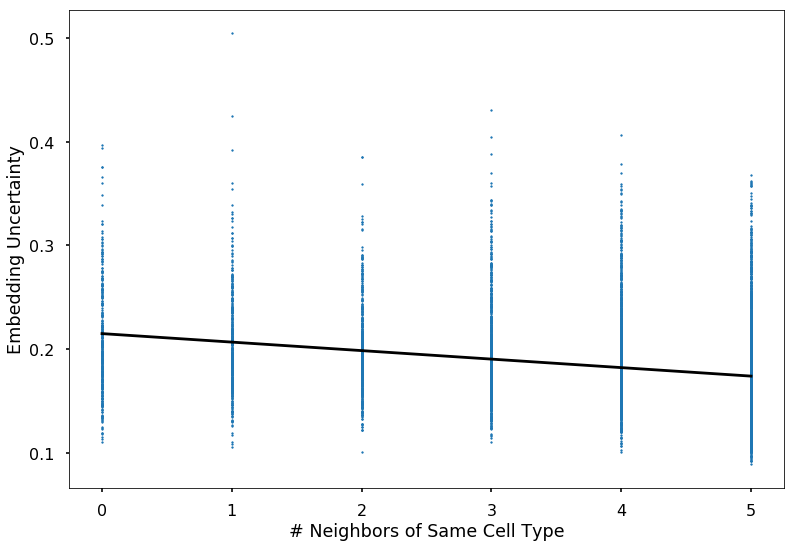

In [39]:
plt.scatter(same_cells, np.mean(fit['x_var'][:,dims], axis = 1), s = 3.0)
plt.plot([0,nn], [intercept, nn*slope + intercept], 'k')
plt.xlabel('# Neighbors of Same Cell Type')
plt.ylabel('Embedding Uncertainty')
plt.show()

In [40]:
import statsmodels.api as sm

In [41]:
x = sm.add_constant(same_cells)

In [42]:
mod = sm.GLM(np.mean(fit['x_var'][:,dims], axis = 1), x, family = sm.families.Gamma())

/Users/architverma/anaconda/lib/python2.7/site-packages/statsmodels/genmod/generalized_linear_model.py:273: DomainWarning: The inverse_power link function does not respect the domain of the Gamma family.
  DomainWarning)


In [43]:
res = mod.fit()

In [44]:
print(res.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:                      y   No. Observations:                 7095
Model:                            GLM   Df Residuals:                     7093
Model Family:                   Gamma   Df Model:                            1
Link Function:          inverse_power   Scale:                        0.059541
Method:                          IRLS   Log-Likelihood:                 12451.
Date:                Mon, 30 Dec 2019   Deviance:                       384.61
Time:                        12:43:30   Pearson chi2:                     422.
No. Iterations:                     6                                         
Covariance Type:            nonrobust                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          4.6068      0.038    122.592      0.0

In [45]:
res.pearson_chi2

422.3221348497567

In [46]:
res.pvalues

array([0.00000000e+000, 2.20996536e-124])

In [47]:
# Lin reg tests

In [48]:
y = np.array(dat.values[:,1:].T, dtype = np.float64)

In [49]:
from sklearn.linear_model import LinearRegression

In [50]:
ols = LinearRegression()

In [51]:
ols.fit(z,y)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
         normalize=False)

In [52]:
residuals = y - ols.predict(z)

In [53]:
from sklearn.decomposition import PCA

In [54]:
pca = PCA(n_components = 10)

In [55]:
zpca = pca.fit_transform(residuals)

In [56]:
pca_results = np.zeros((2,len(clusters),n_repeats))
for i in range(len(clusters)):
    print(i)
    km = KMeans(n_clusters = clusters[i])
    for j in range(n_repeats):
        labs = km.fit_predict(zpca)
        pca_results[0,i,j] = normalized_mutual_info_score(labs, true_labs)
        pca_results[1,i,j] = adjusted_rand_score(labs, true_labs)

0
1
2
3
4


In [57]:
print(np.mean(pca_results[1]))

0.12260160249926182


In [58]:
print(np.mean(pca_results[0]))

0.22388474927930735


In [59]:
import GPy

In [60]:
m = GPy.models.GPRegression(z,y)
m.optimize()

In [61]:
corrected_zero = m.predict(z)
y2 = y - corrected_zero[0]

In [62]:
m2 = GPy.models.GPLVM(y2, 10)
m2.optimize()

In [68]:
zgpy = m2.latent_mean

In [73]:
gpy_results = np.zeros((2,len(clusters),n_repeats))
for i in range(len(clusters)):
    print(i)
    km = KMeans(n_clusters = clusters[i])
    for j in range(n_repeats):
        labs = km.fit_predict(zgpy)
        gpy_results[0,i,j] = normalized_mutual_info_score(labs, true_labs)
        gpy_results[1,i,j] = adjusted_rand_score(labs, true_labs)

0
1
2
3
4


In [75]:
print(np.mean(gpy_results[1]))

0.00019661708971114352


In [76]:
print(np.mean(gpy_results[0]))

0.07866845168397735
